In [16]:
from __future__ import print_function
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import math
import time

%matplotlib inline


### Fonction to display one image

In [17]:
im_shape = [128, 2111]

def plot_im(im):
    plt.figure(figsize=(20, 10))
    plt.imshow(im.reshape(im_shape), aspect='auto')
    plt.grid(False)
    plt.gray()
    plt.show()
    
current_milli_time = lambda: int(round(time.time() * 1000))

### Load files into an array

In [18]:
files = [f for f in glob('*/*.txt') if 'readme' not in f]
print(len(files))
data = np.array([np.loadtxt(f, dtype='int') for f in files])
data_ = data.astype('float32') / data.max()
print("Number of images: "+str(data.shape))

155
Number of images: (155, 128, 2111)


### Store corresponding labels in another array
- "h" for hand
- "g" for gelpad
- "s" for sponge

In [19]:
labels = [f[0] for f in files]
#print(labels)

### Select one image and display it

Here : 25th instance of sponge

kelu124: I'm using np.sqrt to get a "compressed" image. Usually, a log compression takes place, sqrt can give a first approximation. Using 22th sponge, line 70 for the tests

### Display fft along horizontal axis

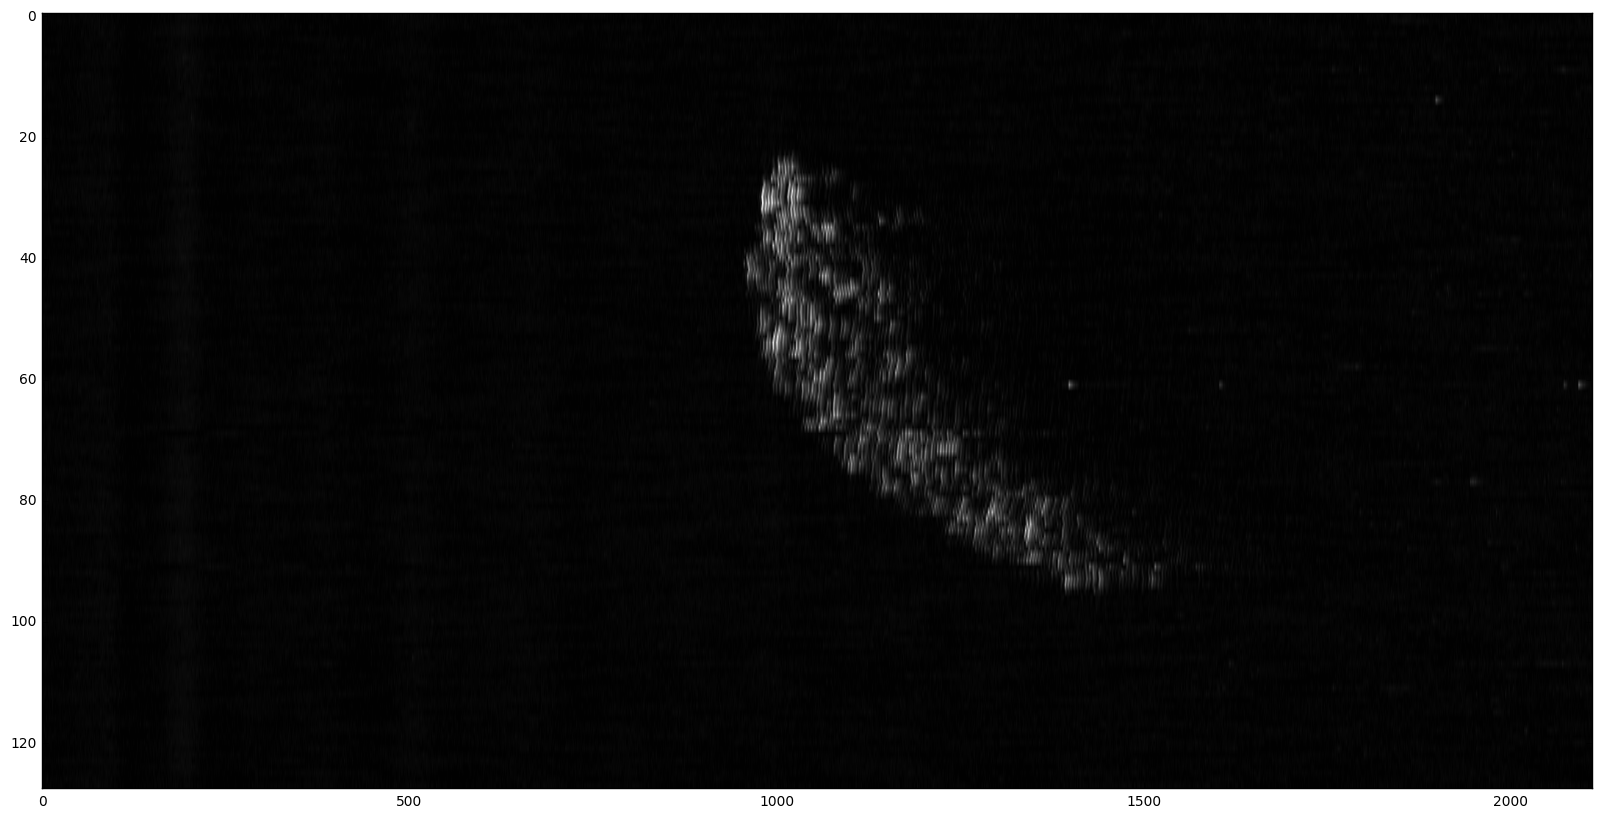

2111


In [20]:
idx_list = np.array([l=='s' for l in labels])
#sample = np.sqrt(data_[idx_list][22])
sample = data_[idx_list][22]
plot_im(sample)
print(len(sample[0]))

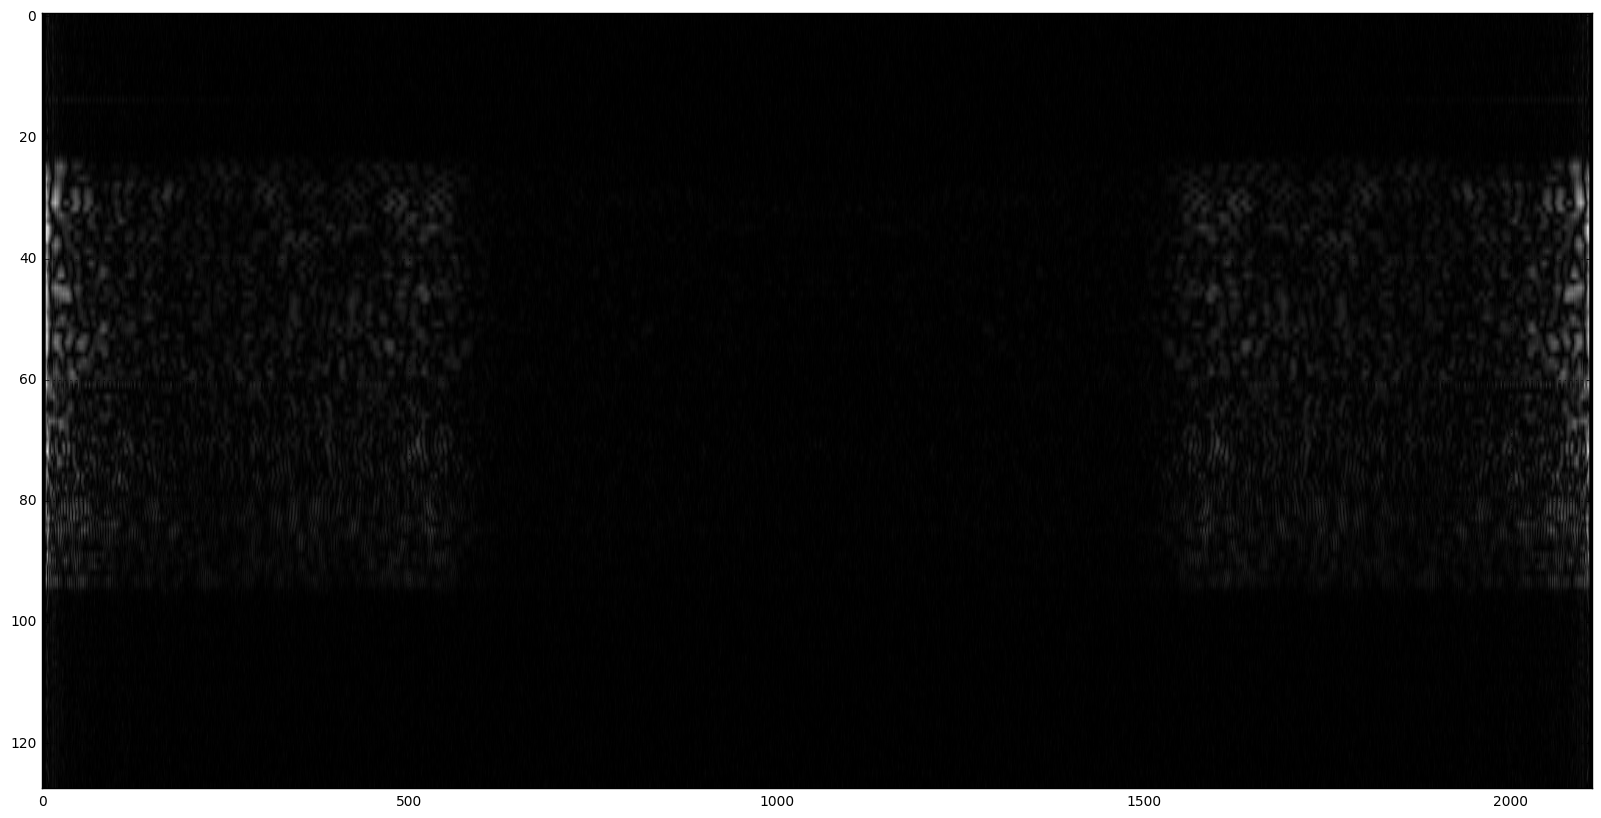

In [21]:
fourier_data = np.fft.fft(sample)
fourier_data_todisplay = np.fft.fft(sample)
for k in range (im_shape[0]):
    for i in range(5):
        fourier_data_todisplay[k][i]=0
        fourier_data_todisplay[k][-1-i]=0
plt.figure(figsize=(20, 10))
plt.imshow(np.abs(np.real(fourier_data_todisplay)).reshape(im_shape), aspect='auto')
#plt.xlim(0, 100)
plt.grid(True)
plt.gray()
plt.show()

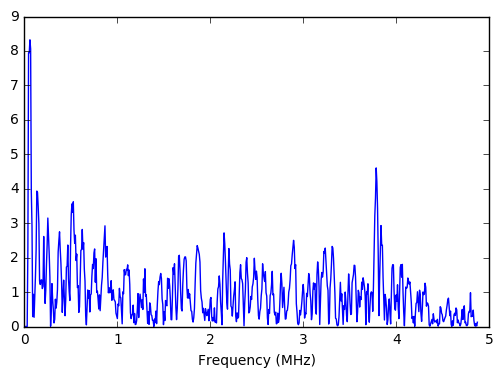

In [22]:
l = float(len(fourier_data_todisplay[70]))
XLimit = int((5.0/8.0)*l/2)
SelectedLine = (np.abs(np.real(fourier_data_todisplay[70])))
XScale = range(XLimit)
for i in range(XLimit):
    XScale[i] = (125.0/8.0)*float(XScale[i])/(1.0*l)
plt.plot(XScale,SelectedLine[0:XLimit]) # avec l'échelle
#plt.plot(SelectedLine[0:XLimit])
plt.xlabel('Frequency (MHz)')
plt.show()

## We see a strange pattern around line 70, let's explore it.

In [23]:
fourier_dataTwo = np.zeros(shape=(data.shape[1],data.shape[2]),dtype=complex)
fourier_dataThree = np.zeros(shape=(data.shape[1],data.shape[2]),dtype=complex) 

for i in range(data.shape[1]):
    for j in range(data.shape[2]):
        fourier_dataTwo[i][j] = fourier_data[i][j]
        fourier_dataThree[i][j] = fourier_data[i][j]

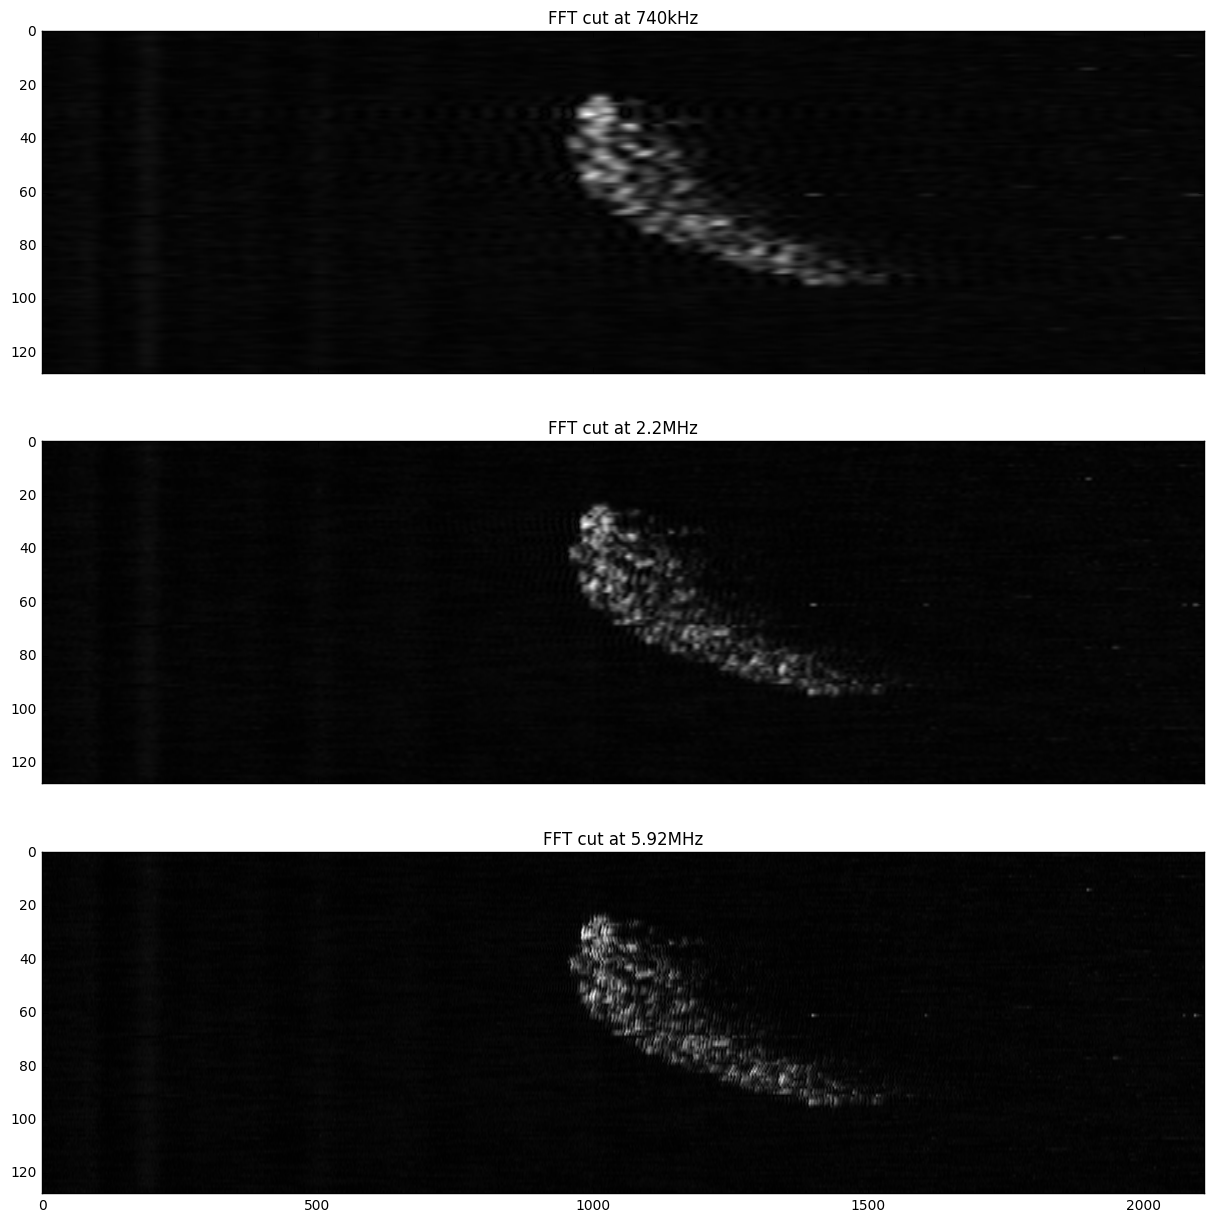

In [24]:
for k in range (im_shape[0]):
    for i in range(im_shape[1]/2):
            if (i > 50):
                fourier_data[k][i]=0
                fourier_data[k][-i]=0
                
fourier_data_inverse = np.abs(np.fft.ifft(fourier_data))


for k in range (im_shape[0]):
    for i in range(im_shape[1]/2):
            if (i > 150):
                fourier_dataTwo[k][i]=0
                fourier_dataTwo[k][-i]=0
                
fourier_data_inverseTwo = np.abs(np.fft.ifft(fourier_dataTwo))


for k in range (im_shape[0]):
    for i in range(im_shape[1]/2):
            if (i > 400):
                fourier_dataThree[k][i]=0
                fourier_dataThree[k][-i]=0
                
fourier_data_inverseThree = np.abs(np.fft.ifft(fourier_dataThree))


f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False,figsize=(15,15))

ax1.imshow(np.abs(fourier_data_inverse).reshape(im_shape), aspect='auto')
ax1.set_title('FFT cut at 740kHz')
ax2.imshow(np.abs(fourier_data_inverseTwo).reshape(im_shape), aspect='auto')
ax2.set_title('FFT cut at 2.2MHz')
ax3.imshow(np.abs(fourier_data_inverseThree).reshape(im_shape), aspect='auto')
ax3.set_title('FFT cut at 5.92MHz')

plt.show()

# Scan conversion

### Creating of a lighted, "decimated" image to make the computation lighter

In [25]:
DECIMATION = 5

Once the decimation decided, lets create the decimated data

In [31]:
depth = int(data.shape[2]/DECIMATION)
size=data.shape[1],depth
DecimatedImg=np.zeros(shape=(size[0],size[1]))

for i in range(size[0]):
    for j in range(size[1]):
        for k in range(DECIMATION):
            DecimatedImg[i][j] = fourier_data_inverseThree[i][DECIMATION*j+k]

#### Creating parameters for the scan conversion

128 lines per image for an angle of 40.0°.. cos:0.766044443119, sin: 0.642787609687
Size of the decimated raw image: (128, 422)
Size of the scan converted image: (422, 414)


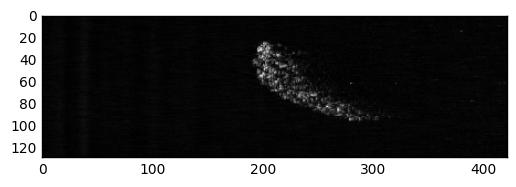

In [32]:
NbOfLines = len(fourier_data_inverse) 
maxAngle = 40.0 # should be found in the metadata
MaxDepth = int(size[1]*math.cos(math.radians(maxAngle)))
ImageWidth = (int(MaxDepth*math.sin(math.radians(maxAngle))))
sizeSC = (size[1],2*ImageWidth)

step = 2.0*maxAngle/(NbOfLines+1)

print(str(NbOfLines)+" lines per image for an angle of "+str(maxAngle)+"°."+". cos:"+str(math.cos(math.radians(maxAngle)))+", sin: "+str(math.sin(math.radians(maxAngle))))
print("Size of the decimated raw image: "+str(size))
print("Size of the scan converted image: "+str(sizeSC))

plt.imshow(DecimatedImg)
plt.show()

#### And creating the angles

In [33]:
# X and Ys
X=np.zeros(shape=(size[0],size[1]))
Y=np.zeros(shape=(size[0],size[1]))
# Image SC X and Y
XX=np.zeros(shape=(sizeSC[0],sizeSC[1]))
YY=np.zeros(shape=(sizeSC[0],sizeSC[1]))
# Initiating matrices
for i in range(size[0]):
    for j in range(size[1]):
        X[i][j] = 1.0*j*math.cos(math.radians(step*i-maxAngle)) 
        Y[i][j] = 1.0*(size[1]+1)/2.0+1.0*j*math.sin(math.radians(step*(i)-maxAngle)) # same
ScanConverted=np.zeros(shape=(size[1],2*ImageWidth))
print ("Taille SC: "+str(ScanConverted.shape)+" / "+str(sizeSC))

Taille SC: (422, 414) / (422, 414)


# Doing the Scan Conversion

not using any caching of table indexes, on high-decimated images.

In [38]:
print(sizeSC)
for i in range(sizeSC[0]):
    if (i<=MaxDepth):
            sweep = int(i*math.sin(math.radians(40)))
            for j in range((sizeSC[1]/2-sweep),(sizeSC[1]/2+sweep)):
                D = (X-i)**2 + (Y-j)**2
                resul = np.unravel_index(D.argmin(), D.shape)
                # here is a basic NN, not even a 2-tap
                #ScanConverted[i][j] = DecimatedImg[resul[0]][resul[1]]
                XX[i][j] =  resul[0]
                YY[i][j] =  resul[1]
                ScanConverted[i][j] = DecimatedImg[resul[0]][resul[1]]
            if not (i%100):
                   print(str(100*i/sizeSC[0])+"%")
    else:
        if not (i%100):
            print(str(100*i/sizeSC[0])+"%")
        for j in range(sizeSC[1]):
            if ( (i**2) + (j-(sizeSC[0]/2))**2 ) < ((sizeSC[0])**2 - 1):
                D = (X-i)**2 + (Y-j)**2
                resul = np.unravel_index(D.argmin(), D.shape)
                #ScanConverted[i][j] = fourier_data_inverse[resul[0]][resul[1]]
                XX[i][j] =  resul[0]
                YY[i][j] =  resul[1]
                ScanConverted[i][j] = DecimatedImg[resul[0]][resul[1]]

(422, 414)
0%
23%
47%
71%
94%


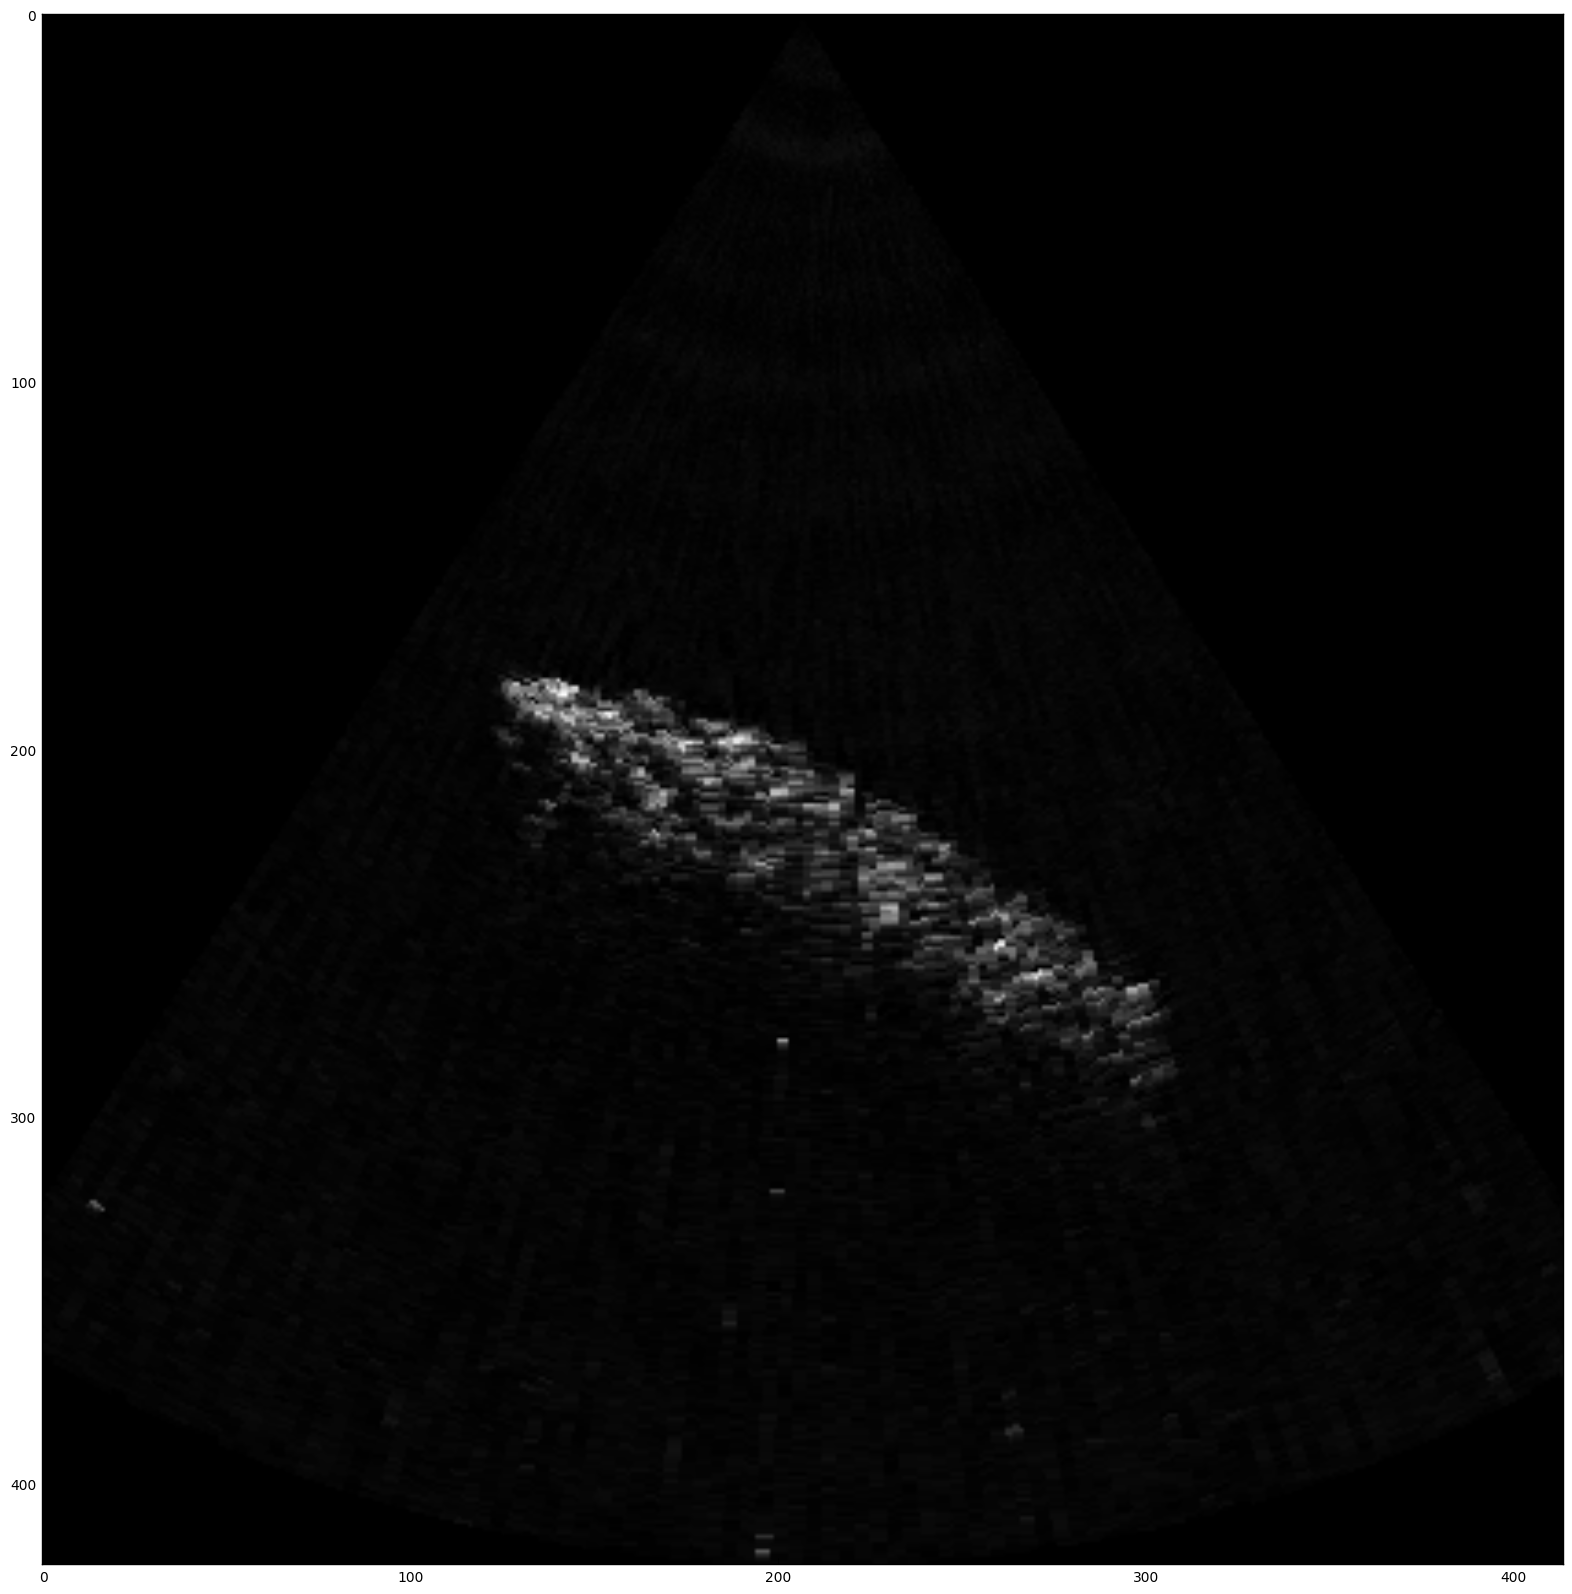

In [39]:
plt.figure(figsize=(20, 20))
plt.imshow(ScanConverted)
plt.grid(False)
plt.gray()
plt.show()